In [3]:
from hmmlearn import hmm
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [4]:
n = 6  # 6个隐藏状态

data = pd.read_csv('沪深300数据.csv', index_col=0)
volume = data['volume']
close = data['close']

logDel = np.log(np.array(data['high'])) - np.log(np.array(data['low']))
logRet_1 = np.array(np.diff(np.log(close)))
logRet_5 = np.log(np.array(close[5:])) - np.log(np.array(close[:-5]))
logVol_5 = np.log(np.array(volume[5:])) - np.log(np.array(volume[:-5]))

# 保持所有的数据长度相同
logDel = logDel[5:]
logRet_1 = logRet_1[4:]
close = close[5:]

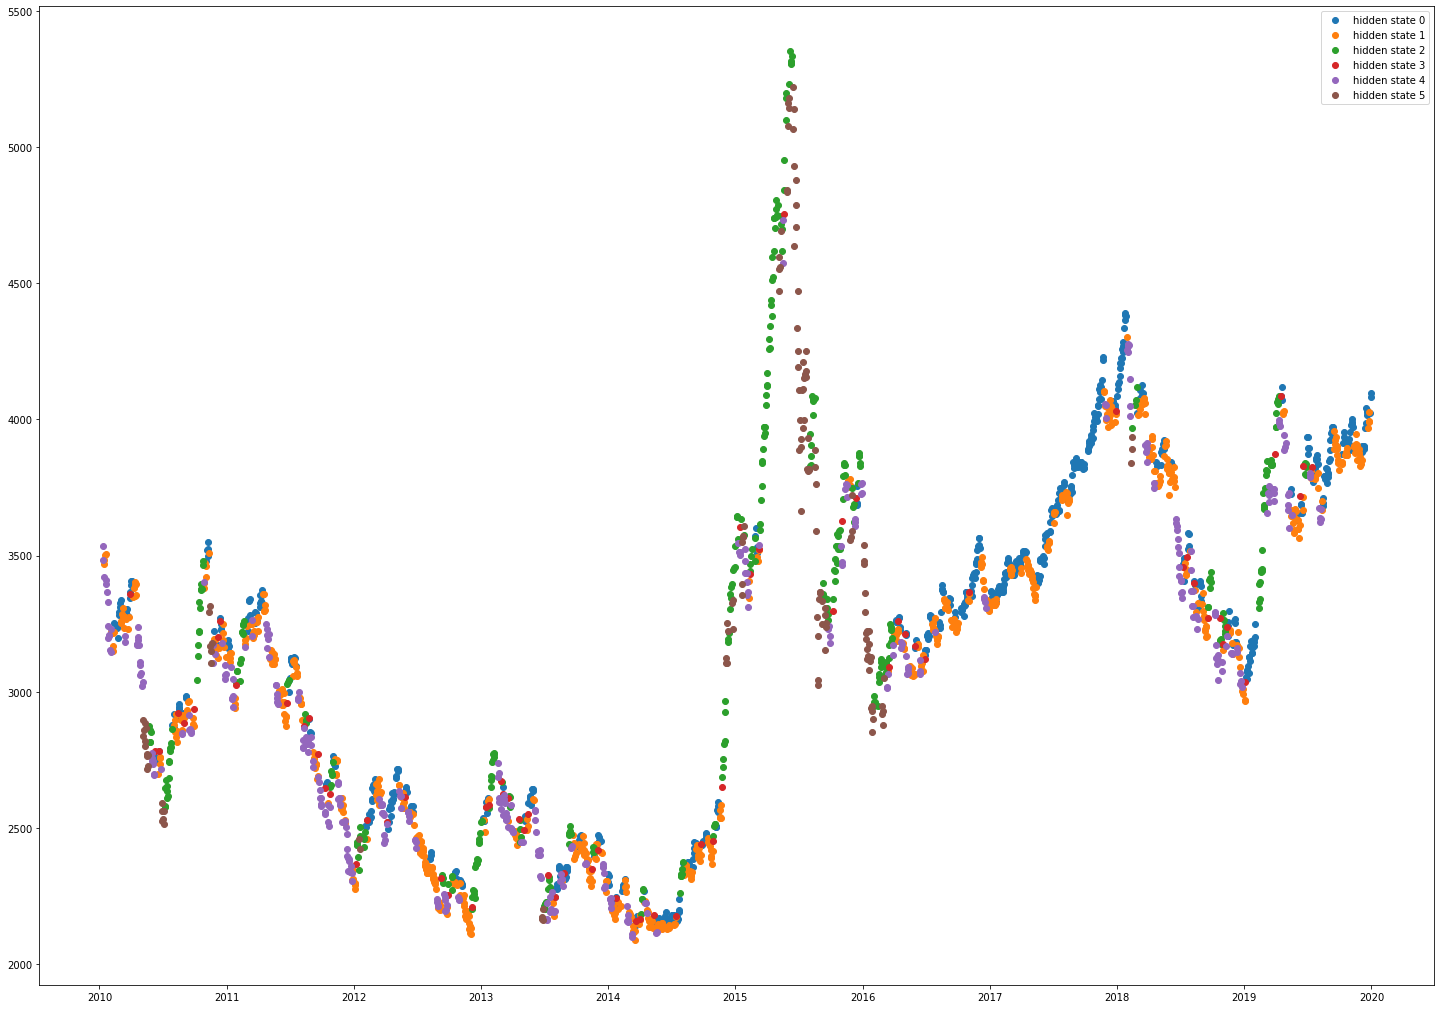

In [5]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Date = pd.to_datetime(data.index[5:])
A = np.column_stack([logDel, logRet_5, logVol_5])

model = hmm.GaussianHMM(n_components=n, covariance_type="full", n_iter=2000).fit(A)
hidden_states = model.predict(A)

plt.figure(figsize=(25, 18))
for i in range(n):
    pos = (hidden_states == i)
    plt.plot_date(Date[pos], close[pos], 'o', label='hidden state %d' % i, lw=2)
    plt.legend()
plt.show()

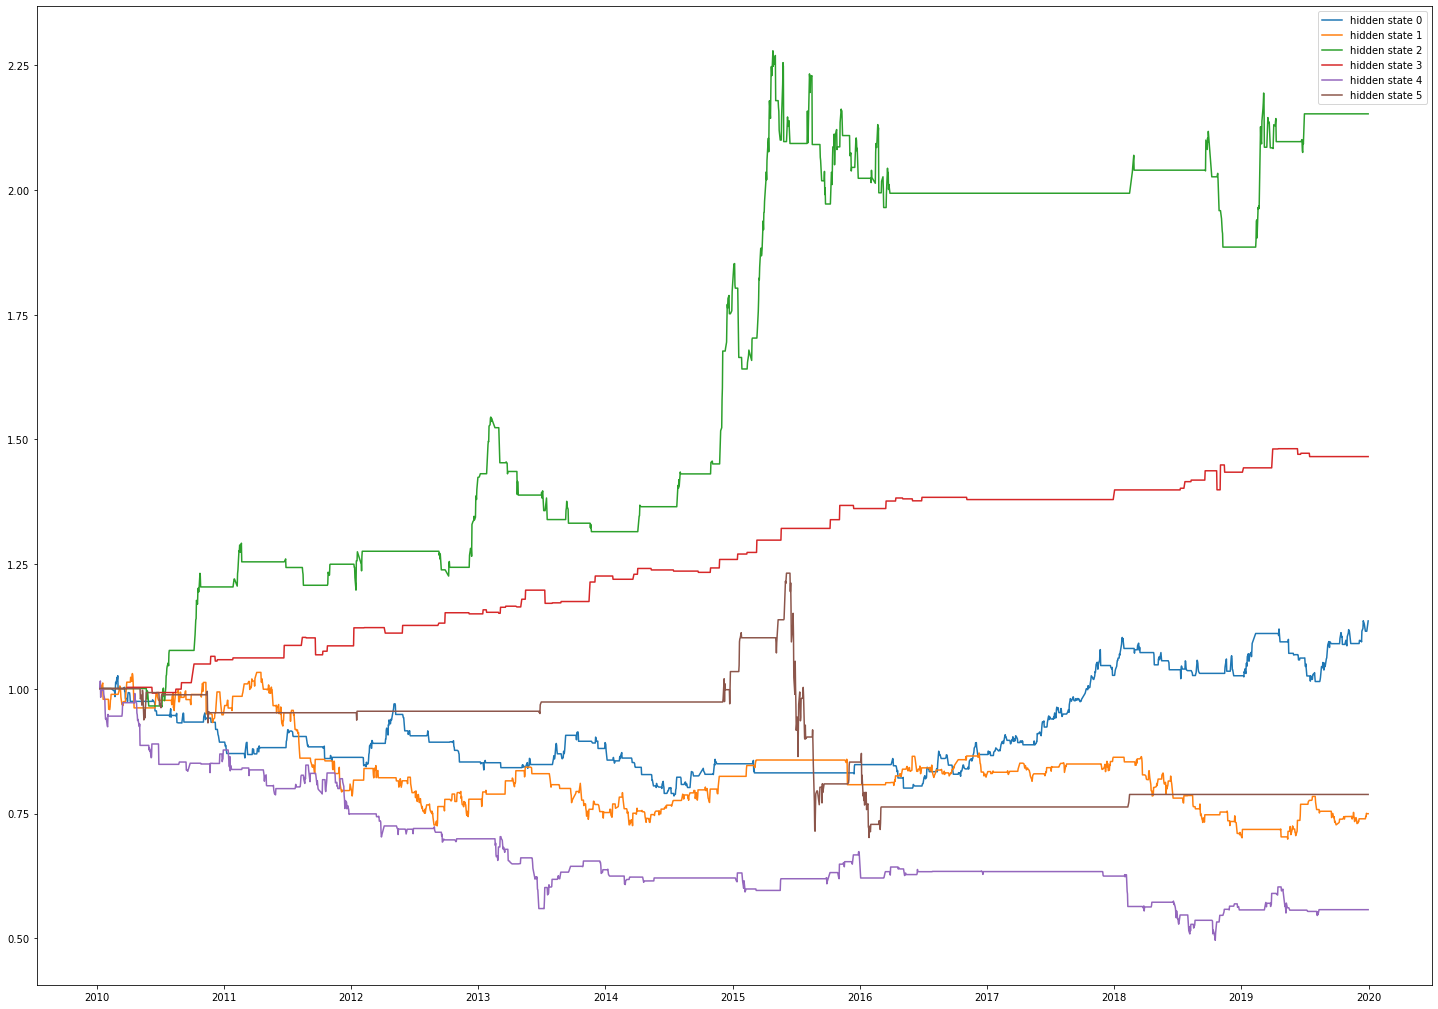

In [6]:
res = pd.DataFrame({'Date': Date, 'logReg_1': logRet_1, 'state': hidden_states}).set_index('Date')
series = res.logReg_1

templist = []
plt.figure(figsize=(25, 18))
for i in range(n):
    pos = (hidden_states == i)
    pos = np.append(1, pos[:-1])
    res['state_ret%d' % i] = series.multiply(pos)
    data_i = np.exp(res['state_ret%d' % i].cumsum())
    templist.append(data_i[-1])
    plt.plot_date(Date, data_i, '-', label='hidden state %d' % i)
    plt.legend()
plt.show()

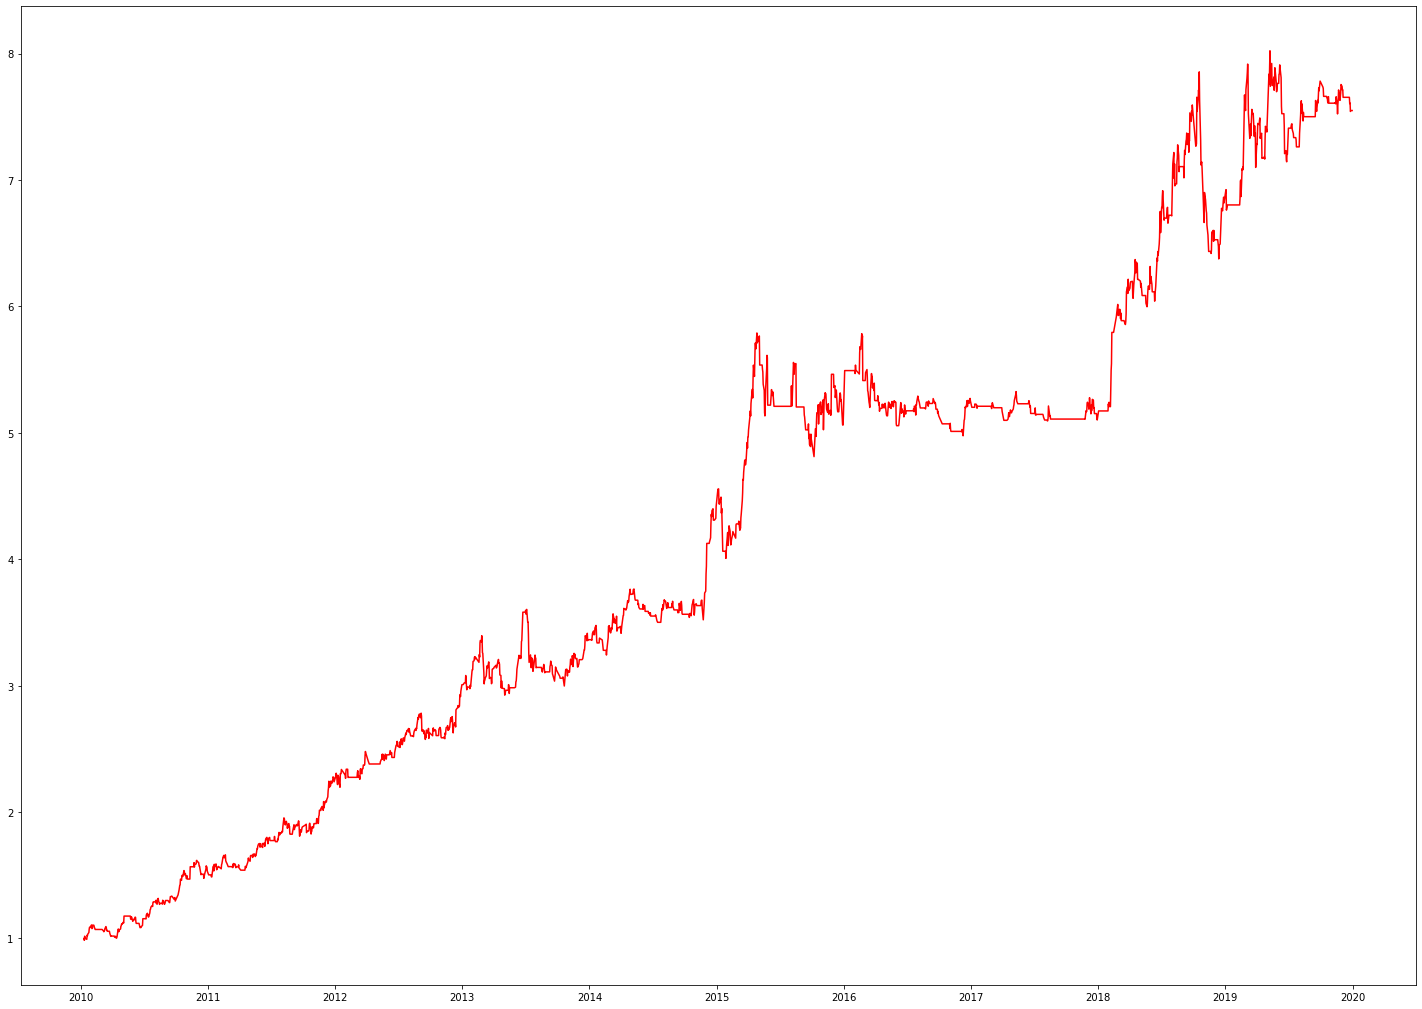

In [7]:
templist = np.array(templist).argsort()
long = (hidden_states == templist[-1]) + (hidden_states == templist[-2])  # 买入
short = (hidden_states == templist[0]) + (hidden_states == templist[1])  # 卖出
long = np.append(0, long[:-1])
short = np.append(0, short[:-1])

plt.figure(figsize=(25, 18))
res['ret'] = series.multiply(long) - series.multiply(short)
plt.plot_date(Date, np.exp(res['ret'].cumsum()), 'r-')
plt.show()

In [8]:
list1 = hidden_states.tolist()

In [9]:
list1.append(None)

In [10]:
len(list1)

2427

In [11]:
def transition(k):
    a = 0
    b = 0
    c = 0
    d = 0
    e = 0
    f = 0
    for i in range(len(list1)-1):
        if list1[i] == k:
            if list1[i+1] == None:
                continue
            elif list1[i+1] == 0:
                a += 1
            elif list1[i+1] == 1:
                b+=1
            elif list1[i+1] == 2:
                c+=1
            elif list1[i+1] == 3:
                d+=1
            elif list1[i+1] == 4:
                e+=1
            elif list1[i+1] == 5:
                f+=1
    return [a/(a+b+c+d+e+f), b/(a+b+c+d+e+f), c/(a+b+c+d+e+f), d/(a+b+c+d+e+f), e/(a+b+c+d+e+f), f/(a+b+c+d+e+f)]

In [12]:
for i in range(6):
    print(transition(i))

[0.8581363004172462, 0.11961057023643949, 0.005563282336578581, 0.0, 0.016689847009735744, 0.0]
[0.06765899864682003, 0.8024357239512855, 0.0, 0.06359945872801083, 0.06359945872801083, 0.0027063599458728013]
[0.03561643835616438, 0.0, 0.8602739726027397, 0.0, 0.07671232876712329, 0.0273972602739726]
[0.5633802816901409, 0.0, 0.4225352112676056, 0.0, 0.014084507042253521, 0.0]
[0.0, 0.15424164524421594, 0.002570694087403599, 0.061696658097686374, 0.7686375321336761, 0.012853470437017995]
[0.0, 0.0, 0.11267605633802817, 0.0, 0.007042253521126761, 0.8802816901408451]


In [13]:
mat = []
for i in range(6):
    mat.append(transition(i))
    
print(mat)

[[0.8581363004172462, 0.11961057023643949, 0.005563282336578581, 0.0, 0.016689847009735744, 0.0], [0.06765899864682003, 0.8024357239512855, 0.0, 0.06359945872801083, 0.06359945872801083, 0.0027063599458728013], [0.03561643835616438, 0.0, 0.8602739726027397, 0.0, 0.07671232876712329, 0.0273972602739726], [0.5633802816901409, 0.0, 0.4225352112676056, 0.0, 0.014084507042253521, 0.0], [0.0, 0.15424164524421594, 0.002570694087403599, 0.061696658097686374, 0.7686375321336761, 0.012853470437017995], [0.0, 0.0, 0.11267605633802817, 0.0, 0.007042253521126761, 0.8802816901408451]]


In [14]:
i = 2 
state = []
count = 200000
np.random.seed(666)
ran = np.random.random_sample([count])

for t in range(count):
    r = ran[t]
    if r <= mat[i][0]:
        i = 0
    elif mat[i][0] <= r <= mat[i][0] + mat[i][1]:
        i = 1
    elif mat[i][0] + mat[i][1] <= r <= mat[i][0] + mat[i][1] + mat[i][2]:
        i = 2
    elif mat[i][0] + mat[i][1] + mat[i][2] <= r <= mat[i][0] + mat[i][1] + mat[i][2] + mat[i][3]:
        i = 3
    elif mat[i][0] + mat[i][1] + mat[i][2] + mat[i][3] <= r <= mat[i][0] + mat[i][1] + mat[i][2] + mat[i][3] + mat[i][4]:
        i = 4
    else:
        i = 5
    state.append(i)

In [15]:
countDict = dict()
proportitionDict = dict()
 
for i in range(6):
    countDict[i] = state.count(i)
    proportitionDict[i] = state.count(i)/len(state)

print(countDict)
print(proportitionDict)

{0: 59229, 1: 60589, 2: 31028, 3: 5730, 4: 31234, 5: 12190}
{0: 0.296145, 1: 0.302945, 2: 0.15514, 3: 0.02865, 4: 0.15617, 5: 0.06095}


In [16]:
Astate = state[150000:]

countDict1 = dict()
proportitionDict1 = dict()

for i in range(6):
    countDict1[i] = Astate.count(i)
    proportitionDict1[i] = Astate.count(i)/len(Astate)

print(countDict1)
print(proportitionDict1)

{0: 15529, 1: 15263, 2: 7391, 3: 1467, 4: 7525, 5: 2825}
{0: 0.31058, 1: 0.30526, 2: 0.14782, 3: 0.02934, 4: 0.1505, 5: 0.0565}


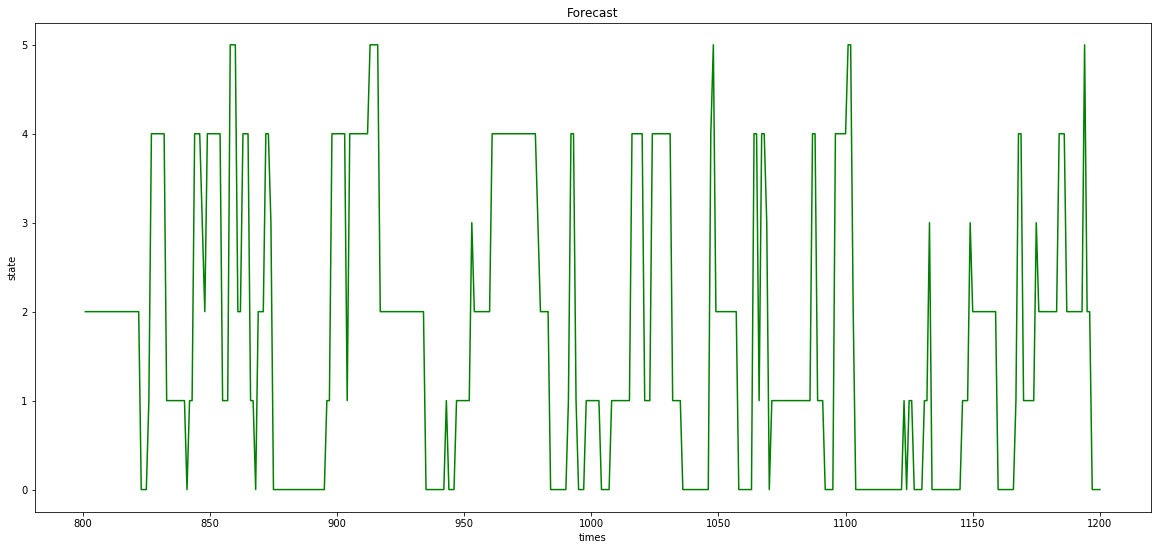

In [17]:
plt.figure(figsize=(20, 9))
plt.title('Forecast')
plt.plot(range(801,1201), state[800:1200], color='green')
plt.xlabel('times')
plt.ylabel('state')
plt.show()

In [18]:
np.random.randint(17, 20, size=(9,4))

array([[17, 17, 18, 19],
       [19, 18, 19, 18],
       [17, 18, 19, 17],
       [19, 18, 17, 18],
       [18, 18, 18, 19],
       [18, 19, 19, 18],
       [17, 19, 17, 18],
       [17, 19, 19, 18],
       [19, 18, 18, 19]])